# Attempt 2: Six Models with Dummy Variables

## idea: 
* Train 6 models, one for each product group
* In the raw data, columns 20 onward are product-group-specific attributes of the equipements.
    * Add `k-1` dummy variables for columns with `k` categorical codes (k different descriptions)
        * In order for the feature matrices `X_train` and `X_test` to be of the same "width"...
            * if a attribute shows up in the training set but not in the test set, add a column of zeros to `X_test`
            * if a attribute shows up in the test set but not in the training set, drop this column in `X_test`
        
    * Drop a column if it only has one categorical code, either
        * all NaNs -- i.e. the feature does not apply to this product group
        * all have the same descriptions -- not intereting
    

## features matrix:
* `Age`: sales date - year made
* Equipement attribute dummy variables

<br>
<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>

In [614]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.grid_search import GridSearchCV 

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
df_train = pd.read_csv(zipfile.ZipFile('data/Train.zip', mode='r').open('Train.csv'), low_memory=False, parse_dates=['saledate'])
df_test = pd.read_csv(zipfile.ZipFile('data/Test.zip', mode='r').open('test.csv'), low_memory=False, parse_dates=['saledate'])

# df_train = pd.read_csv('data/Train.csv', parse_dates=['saledate'])
# df_test = pd.read_csv('data/test.csv', parse_dates=['saledate'])

<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>
<br>
# Data Cleaner

In [600]:
def df_cleaner(df, drop_mono=True, dropna=False):
    """
    :type df: pandas.DataFrame
    :rtype df: pandas.DataFrame
    """
    
    df = df.copy()
    
    
    ## `saledate` converted to pd.datetime format when loading data
    df['Age'] = (df['saledate'].dt.year - df['YearMade']).astype(float)
    df.drop(['saledate', 'YearMade'], axis=1, inplace=True)
    df = df[(df.Age > 0) & (df.Age < 50)]
    
    
#     df = df[['Age', 'Enclosure','SalePrice']]   
#     return df


    ## confirmed drop
    df.drop([\
             'SalesID',
             'auctioneerID',
             
             'fiModelDescriptor', 
             'fiProductClassDesc',
             'fiModelDesc',
             'fiSecondaryDesc', 
             'fiModelSeries', 
             'fiBaseModel',
             
             'ProductGroup',
             'ProductGroupDesc', 
            ], axis=1, inplace=True)


    ## temporary drop
    df.drop([\
             'MachineID',
             'ModelID',
             'datasource',
             'state',
             
             'MachineHoursCurrentMeter',
             'UsageBand',
            ], axis=1, inplace=True)
    
      ## `UsageBand` is ordered -- doesn't matter for DecisionTrees
#     df["UsageBand"].fillna("Medium", inplace=True)
#     df.loc[df.UsageBand == "Low","UsageBand"] = 1.
#     df.loc[df.UsageBand == "Medium","UsageBand"] = 2.
#     df.loc[df.UsageBand == "High","UsageBand"] = 3.
#     df["UsageBand"].fillna(0, inplace=True)


      ## order `datasource` is by low, medium, high fill-in percentage -- doesn't matter for Decision Trees
#     df["datasource"].fillna(0, inplace=True)
#     df.loc[df.datasource == 132,"datasource"] = 0.
#     df.loc[df.datasource == 149,"datasource"] = 0.
#     df.loc[df.datasource == 136,"datasource"] = 10.
#     df.loc[df.datasource == 121,"datasource"] = 20.
#     df.loc[df.datasource == 127,"datasource"] = 20.
#     df['datasource'] = df['datasource'].astype(float)

    
    
    ## random drop
    features = [ \
                 'ProductSize',
                 'Blade_Extension', 
                 'Blade_Width', 
                 'Pushblock', 
                 'Scarifier', 
                 'Tire_Size', 
                 'Coupler_System',
                 'Hydraulics_Flow',
                 'Blade_Type',
                 'Stick_Length',
                 'Ripper',
                 'Coupler',
                 'Undercarriage_Pad_Width',
                 'Thumb',
                 'Transmission',
                 'Ride_Control',
                 'Grouser_Type',
                 'Tip_Control',
                 'Drive_System',
                 'Travel_Controls',
                 'Forks',
                 'Enclosure_Type',
                 'Differential_Type',
                 'Steering_Controls',
                 'Pattern_Changer',
                 'Engine_Horsepower',
                 'Track_Type',
                 'Stick',
                 'Backhoe_Mounting',
                 'Pad_Type',
                 'Turbocharged',
                 'Grouser_Tracks',
                 'Enclosure',
                 'Hydraulics',
                
             ]

    ## remove features with too many nulls
#     for fname in features:
#         if df[fname].isnull().sum().astype(float) / len(df) >= 0.01:
#             df.drop(fname, axis=1, inplace=True)

    df.drop(features, axis=1, inplace=True)


    
    
    ## convert categorical columns to numeric
    for cname in df.columns:
        if df[cname].dtype == 'O':
            
            ## By interger label (technically incorrect way):
            #df[cname].fillna(0, inplace=True)
            #df[cname] = pd.Categorical(df[cname]).codes
            
            ## By creating dummy columns:
            df[cname].fillna(0, inplace=True)
            if len(df[cname].unique()) >= 2: # anything < 2 has no variation
                df = pd.concat([df, pd.get_dummies(df[cname], prefix=cname)[1:]], axis=1)
            elif not drop_mono:
                df = pd.concat([df, pd.get_dummies(df[cname], prefix=cname)[0:]], axis=1)
            df.drop(cname, axis=1, inplace=True)
                
        else:
#             df[cname].fillna(df[cname].mean())
            df[cname].fillna(df[cname].median())
        
    
    ## catch leftover NaN's: drop when fit but fill when predict
    if dropna:
        df.dropna(inplace=True)
        # df = df[df.datasource > 0]
        # df.drop('datasource', axis=1, inplace=True)
    else:
        df.fillna(0, inplace=True)
        
    
    return df

### Tester

In [601]:
df_cleaner(df_train[:3], drop_mono=True)

,SalePrice,Age,state_Alabama,state_New York,state_North Carolina
0,66000,2,0,0,0
1,57000,8,0,0,1
2,10000,3,0,1,0


<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>
<br>
# Model

In [552]:
def fit(base_estimator, df, mute=False):
    """
    :type base_estimator: sklearn estimator
    :type df: pandas.DataFrame
    :type mute: bool
    :rtype: dict{sklearn estimators}
    """
    
    df = df.copy()
    
    ## from quick grid search
    best_params = {'BL': {'max_features': 0.4, 'max_depth': 12},
                   'WL': {'max_features': 0.4, 'max_depth': 14},
                   'SSL': {'max_features': 0.4, 'max_depth': 100},
                   'TEX': {'max_features': 0.5, 'max_depth': 14},
                   'TTT': {'max_features': 0.7, 'max_depth': 11},
                   'MG': {'max_features': 0.7, 'max_depth': 12}}
        
        
    models = {}   # {ProductGroup: (estimators, feature_names)}
    grpdf = df.groupby('ProductGroup')
    
    for key, grp in grpdf:
        
        print 'Training', key
        
        df2 = df[df['ProductGroup'] == key]
        df2 = df_cleaner(df2, drop_mono=True, dropna=True)
        
        y = df2['SalePrice'].values
        df2.drop('SalePrice', axis=1, inplace=True)
        X = df2.values
        
        if not mute:
            print X.shape
                    
                
        estimator = clone(base_estimator)    
#         estimator.set_params(**best_params[key])

        if 'linear_model' in base_estimator.__class__.__module__:
            X = X.astype(float)
            
            estimator = Pipeline([('scaler', Normalizer()),
                                  ('base_estimator', clone(base_estimator))])
            
        
        models[key] = (estimator.fit(X,y), set(df2.columns))

    return models

### Tester

In [553]:
models = fit(RandomForestRegressor(), df_train[:5], mute=True)

Training SSL
Training TEX
Training WL


<hr style='background-color: #fff; border-top: 2px dotted #8c8b8b;'>

In [554]:
def rmsle(y, y_pred):
    """
    :type y: numpy.array
    :type y_pred: numpy.array
    :rtype: float
    """
    return np.sqrt(np.sum((np.log(y_pred + 1) - np.log(y + 1))**2) / len(y))

In [568]:
def predict(models, df, mute=False):
    """
    :type models: dict{sklearn estimators}
    :type df: pandas.DataFrame
    :type mute: bool
    :rtype: numpy.array
    """

    df = df.copy()
    
    df.index = range(len(df))  # rename rows so we can later map predictions back in order

    has_y = 'SalePrice' in df.columns
    y_final = np.zeros(len(df))
    grpdf = df.groupby('ProductGroup')
    
    for key, grp in grpdf:
        
        print 'Testing', key
        
        df2 = df[df['ProductGroup'] == key]
        df2 = df_cleaner(df2, drop_mono=True, dropna=False)
        
        
        if has_y:
            y = df2['SalePrice'].values
        
        
        estimator, features = models[key]
        
        ## drop features not in model -- note: this will drop `SalePrice` column
        for cname in df2.columns:
            if cname not in features:
                df2.drop(cname, axis=1, inplace=True)
        
        ## add features not in df
        cnames = set(df2.columns)
        for fname in features:
            if fname not in cnames:
                df2[fname] = 0

        X = df2.values
        
        if estimator.__class__.__name__ == 'Pipeline':
            X = X.astype(float)
        
        y_final[list(df2.index)] += estimator.predict(X)
    
    
    if has_y:
        print rmsle(df['SalePrice'].values, y_final)
#         print r2_score(df['SalePrice'].values, y_final)
        
    return y_final

### Tester

In [566]:
y_pred = predict(models, df_train[:3], mute=True)

Testing SSL
Testing WL
0.886931675688


<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>
<br>
# Quick Test -- 2000 Random Observations
***(n.b.: comment out "`rand_i = rand_i[:2000]`" for a full test on `Train.csv` data)***

In [602]:
np.random.seed(42)

rand_i = range(len(df_train))
np.random.shuffle(rand_i)
# rand_i = rand_i[:2000]
test_size = int(len(rand_i)*0.2)

qt_df_test = df_train.iloc[rand_i[:test_size], :]
qt_df_train = df_train.iloc[rand_i[test_size:], :]


## Bad models: 
# models = fit(Ridge(), qt_df_train, mute=True)
# models = fit(Lasso(), qt_df_train, mute=True)
# models = fit(LinearRegression(), qt_df_train, mute=True)
# models = fit(AdaBoostRegressor(Ridge()), qt_df_train, mute=True)
# models = fit(AdaBoostRegressor(Lasso()), qt_df_train, mute=True)
# models = fit(AdaBoostRegressor(LinearRegression()), qt_df_train, mute=True)

## OK models:
# models = fit(RandomForestRegressor(50, n_jobs=-1), qt_df_train, mute=True)
# models = fit(GradientBoostingRegressor(), qt_df_train, mute=True)
models = fit(AdaBoostRegressor(), qt_df_train, mute=True)

y_pred = predict(models, qt_df_test)

Training BL
Training MG
Training SSL
Training TEX
Training TTT
Training WL
Testing BL
Testing MG
Testing SSL
Testing TEX
Testing TTT
Testing WL
3.10733836901


/Users/l/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


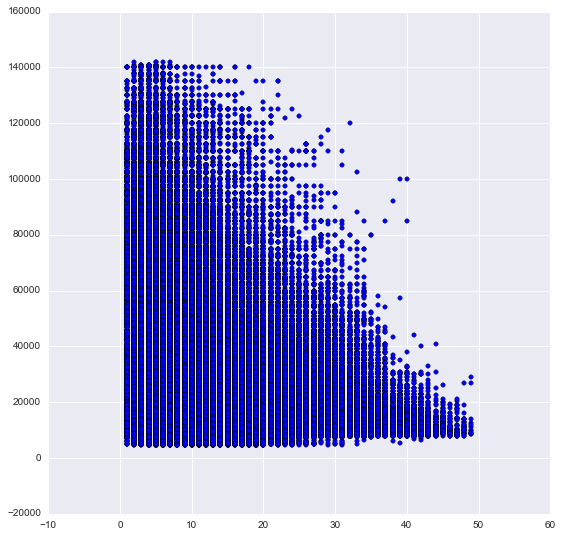

In [618]:
df_simplest = df_train[['saledate', 'YearMade', 'SalePrice']]
df_simplest['Age'] = (df_simplest['saledate'].dt.year - df_simplest['YearMade']).astype(float)
df_simplest = df_simplest[(df_simplest.Age > 0) & (df_simplest.Age < 50)]
model = RandomForestRegressor(50, n_jobs=-1)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.scatter(df_simplest['Age'], df_simplest['SalePrice'])
plt.show()

## Observations:
* Linear models yield -ve `r2_score` -- `r2_score` is negative when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.
<br><br>
* Converting `X` to float results in -ve `r2_score` even for DecisionTree-based models
<br><br>


## At 80-20 split:

| Data Set | Classifier | Categorical | Add Features | `r2_score` |
|----------|------------|-------------|--------------|---------|
| Quick | RandomForestRegressor | dummy + drop mono |  | 0.191408897105 |
| Quick | RandomForestRegressor | dummy + drop mono <br> num col fillna(median)|  | 0.191408897105 |
| Quick | RandomForestRegressor | dummy + keep mono |  | -0.0108693750281 |
| Quick | RandomForestRegressor | int + 2 |  | -0.00682274487991 |
| Quick | RandomForestRegressor | int |  | -0.00682274487991 |
* dummy + drop mono performs better

| Data Set | Classifier | Categorical | Add Features | `r2_score` |
|----------|------------|-------------|--------------|---------|
| Quick | RandomForestRegressor | dummy + drop mono | `state` | 0.165979479522 |
| Quick | RandomForestRegressor | dummy + drop mono | `state` <br> `MachineHoursCurrentMeter` | 0.103512977997 |
| Quick | RandomForestRegressor | dummy + drop mono | `state` <br> `UsageBand` | 0.168793717001 |
| Quick | RandomForestRegressor | dummy + drop mono | `state` <br> `MachineHoursCurrentMeter` <br> `UsageBand` | 0.0790132227099 |
| Quick | RandomForestRegressor | dummy + drop mono | `MachineHoursCurrentMeter` <br> `UsageBand` | -0.0928105593064 |
| Quick | RandomForestRegressor | dummy + drop mono | `UsageBand` (ordered 1,2,3) | 0.164617794259 |
| Quick | RandomForestRegressor | dummy + drop mono | `state`  <br> `UsageBand` (1,2,3) | 0.166493058929 |
* Of these, just `state` alone is the best, but lower than not adding `state`

| Data Set | Classifier | Categorical | Add Features | `r2_score` |
|----------|------------|-------------|--------------|---------|
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0,1,2) | 0.148253110431 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0,1,2 drop 0) <br> `UsageBand` (1,2,3) | 0.0555819919356 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0,1,2 drop 0) | 0.00102101293298 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (1,2,3) | 0.152608020099 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,10.,20.)<br> `UsageBand` (1,2,3) | 0.152608020099 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (1.,2.,3.) | 0.151174098746 |

* Converting `datasource` into float -- column becomes a "weight" rather than integer category -- better score
    * but doesn't matter what the weights are
* Converting `UsageBand` into float -- worse 

| Data Set | Classifier | Categorical | Add Features | `r2_score` |
|----------|------------|-------------|--------------|---------|
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (Nan=0,1,2,3) | 0.160049950667 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (Nan=Low,1,2,3) | 0.149016915116 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (Nan=Med,1,2,3) | 0.152608020099 |
| Quick | RandomForestRegressor | dummy + drop mono | `datasource` (0.,5.,10.)<br> `UsageBand` (Nan=High,1,2,3) | 0.15977995566 |
* For `UsageBand`, separate NaNs into its own category

<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>
<br>

# Quick Grid Search
***(n.b.: comment out "`rand_i = rand_i[:4000]`" for a full search on `Train.csv` data)***

In [383]:
df_train['ProductGroup'].unique()

array(['WL', 'SSL', 'TEX', 'BL', 'TTT', 'MG'], dtype=object)

In [412]:
df_pg = df_cleaner(df_train[df_train.ProductGroup == 'MG'])
y = df_pg['SalePrice'].values
X = df_pg.drop('SalePrice', axis=1).values
print X.shape

np.random.seed(42)
rand_i = range(len(y))
np.random.shuffle(rand_i)
rand_i = rand_i[:4000]

(22604, 198)


In [415]:
searchables = [{'max_depth': [11, 12, 13],
                'max_features': [0.8, 0.6, 0.7]}]
gsCV = GridSearchCV(RandomForestRegressor(50),
                    searchables,
                    scoring='r2',
                    verbose=0)
gsCV.fit(X[rand_i], y[rand_i])
print gsCV.best_score_
print gsCV.best_params_

0.780382629259
{'max_features': 0.7, 'max_depth': 12}


## From random sampling 4000 observations each:

| ProductGroup | Best r2_score | Best Params |
|--|--|--|
| BL | 0.679897536415 | {'max_features': 0.4, 'max_depth': 12} |
| WL | 0.740451932209 | {'max_features': 0.4, 'max_depth': 14} |
| SSL | 0.496453625798 | {'max_features': 0.4, 'max_depth': 100} |
| TEX | 0.749668178126 | {'max_features': 0.5, 'max_depth': 14} |
| TTT | 0.704387501783 | {'max_features': 0.7, 'max_depth': 11} |
| MG | 0.780382629259 | {'max_features': 0.7, 'max_depth': 12} |

* Quick test using these parameters: `r2_score` = 0.178892261946 -- not better

<hr style='	background-color: #fff; border-top: 2px dashed #8c8b8b;'>
<br>

# Moment of Truth... (dum dum dum)

In [466]:
models = fit(RandomForestRegressor(50, n_jobs=-1), df_train, mute=True)

Training BL
Training MG
Training SSL
Training TEX
Training TTT
Training WL


In [467]:
y_pred = predict(models, df_test)

Testing BL
Testing MG
Testing SSL
Testing TEX
Testing TTT
Testing WL


In [468]:
## Output data for submission:
result_df = pd.DataFrame(np.c_[df_test['SalesID'].values, y_pred], 
                         columns = ['SalesID', 'SalePrice'])
result_df.to_csv('result_individual_dropfeatures.csv', index=False)


# Run in terminal: python score_model.py result.csv

# Don't want to Slack out my results...

In [446]:
test_solution = pd.read_csv('data/do_not_open/test_soln.csv')

In [470]:
rmsle(test_solution['SalePrice'], y_pred)

3.2995851396238445

In [471]:
result_group = pd.read_csv('result_group_best.csv')

In [472]:
rmsle(test_solution['SalePrice'], result_group['SalePrice'])

0.29570354605279137